# Plots extension showcase

This example demonstrates all plotting helpers provided by the Fastback
Plots extension. It runs a small backtest to populate collectors, trades,
and cashflows, then renders each plot type for illustration.

In [1]:
using Fastback
using Dates
using Plots
using CSV
using DataFrames
using Statistics

---------------------------------------------------------
Simple backtest to generate plot data

In [2]:
acc = Account(;
    funding=AccountFunding.Margined,
    base_currency=CashSpec(:USDT),
    broker=BinanceBroker(; maker_derivatives=0.0004, taker_derivatives=0.0004),
);
usdt = cash_asset(acc, :USDT)
deposit!(acc, :USDT, 10_000.0)
perp = register_instrument!(
    acc,
    perpetual_instrument(
        Symbol("BTCUSDT-PERP"),
        :BTC,
        :USDT;
        margin_requirement=MarginRequirement.PercentNotional,
        margin_init_long=0.10,
        margin_init_short=0.10,
        margin_maint_long=0.05,
        margin_maint_short=0.05,
    ),
)

collect_balance, balance_data = periodic_collector(Float64, Hour(1));
collect_equity, equity_data = periodic_collector(Float64, Hour(1));
collect_open, open_orders_data = periodic_collector(Int, Hour(1));
collect_drawdown, drawdown_data = drawdown_collector(DrawdownMode.Percentage, Hour(1));
collect_gross, gross_exposure = periodic_collector(Float64, Hour(1));
collect_net, net_exposure = periodic_collector(Float64, Hour(1));
collect_long, long_exposure = periodic_collector(Float64, Hour(1));
collect_short, short_exposure = periodic_collector(Float64, Hour(1));

# load synthetic USD-M perp data
# columns: dt, bid, ask, last, funding_rate
data_path = "../data/usdm_perp_1h.csv";

# if data path doesn't exist, try to change working directory
isfile(data_path) || cd("src/plotting")

# parse CSV (hourly rows)
df = DataFrame(CSV.File(data_path; dateformat="yyyy-mm-dd HH:MM:SS"));
sort!(df, :dt);
n_steps = nrow(df);

window = 24;
deadband = 0.002;
leverage_target = 2.0;

for i in 1:n_steps
    row = df[i, :]
    dt = row.dt
    bid = row.bid
    ask = row.ask
    last = row.last
    funding_rate = row.funding_rate
    marks = [MarkUpdate(perp.index, bid, ask, last)]
    funding = funding_rate == 0.0 ? nothing : [FundingUpdate(perp.index, funding_rate)]
    process_step!(acc, dt; marks=marks, funding=funding, liquidate=true)

    if i >= window
        ma = mean(@view df.last[i-window+1:i])
        signal = last > (1 + deadband) * ma ? 1.0 : (last < (1 - deadband) * ma ? -1.0 : 0.0)

        pos = get_position(acc, perp)
        target_qty = signal == 0.0 ? 0.0 : signal * leverage_target * equity(acc, usdt) / last
        delta_qty = target_qty - pos.quantity

        if abs(delta_qty) > 1e-8
            order = Order(oid!(acc), perp, dt, last, delta_qty)
            fill_order!(acc, order; dt=dt, fill_price=last, bid=bid, ask=ask, last=last)
        end
    end

    if should_collect(balance_data, dt)
        collect_balance(dt, cash_balance(acc, usdt))
        eq = equity(acc, usdt)
        collect_equity(dt, eq)
        collect_drawdown(dt, eq)
        pos = get_position(acc, perp)
        collect_open(dt, pos.quantity == 0.0 ? 0 : 1)
        notional = pos.quantity * last * perp.multiplier
        long_exp = max(notional, 0.0)
        short_exp = min(notional, 0.0)
        gross_exp = long_exp - short_exp
        collect_gross(dt, gross_exp)
        collect_net(dt, notional)
        collect_long(dt, long_exp)
        collect_short(dt, short_exp)
    end
end

pos = get_position(acc, perp)
if pos.quantity != 0.0
    row = df[end, :]
    order = Order(oid!(acc), perp, row.dt, row.last, -pos.quantity)
    fill_order!(acc, order; dt=row.dt, fill_price=row.last, bid=row.bid, ask=row.ask, last=row.last)
end

[Trade] order=(oid=614, symbol=BTCUSDT-PERP) tid=614 date=2024-01-30 23:00:00 fill_px=42898.89 USDT fill_qty=0.56 BTC remaining_qty=0.00 BTC fill_pnl_settle=-0.53 USDT realized_qty=-0.56 BTC commission_quote=9.57 USDT realized_commission_quote=19.22 USDT commission_settle=9.57 USDT cash_delta_settle=-10.10 USDT pos_qty=-0.56 BTC pos_price=43257.39 USDT reason=Normal

---------------------------------------------------------
Basic plot helpers

Balance plot

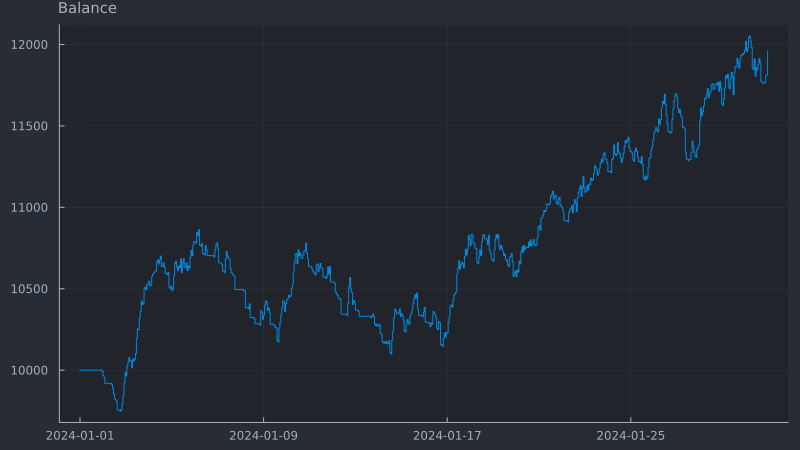

In [3]:
Fastback.plot_balance(balance_data)

Equity plot

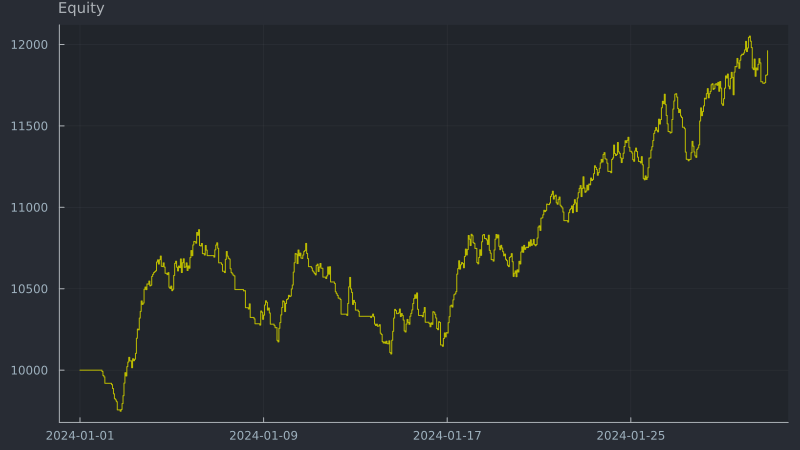

In [4]:
Fastback.plot_equity(equity_data)

Equity plot (index x-axis)

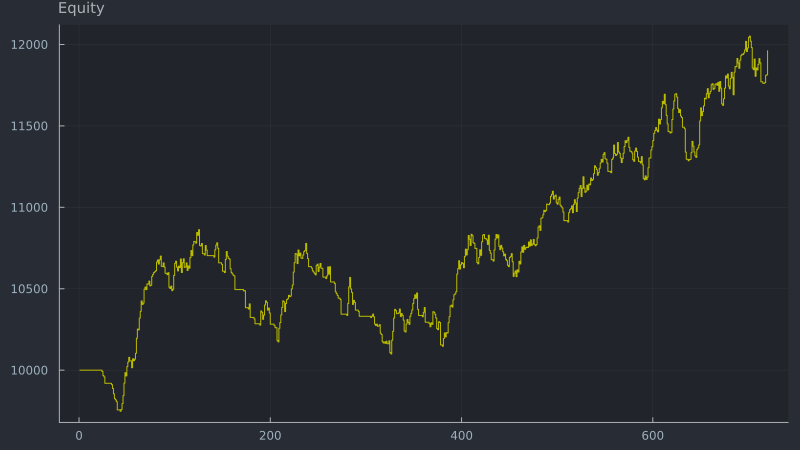

In [5]:
Fastback.plot_equity(equity_data; xaxis_mode=:index)

Open orders plot

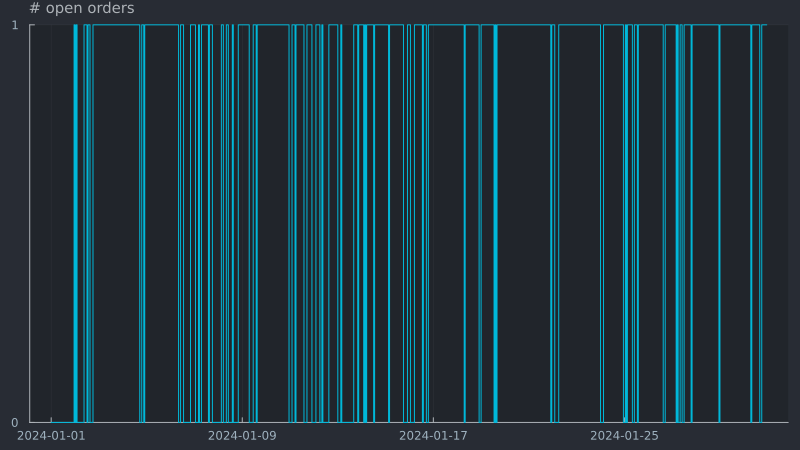

In [6]:
Fastback.plot_open_orders_count(open_orders_data)

Open orders plot (index x-axis)

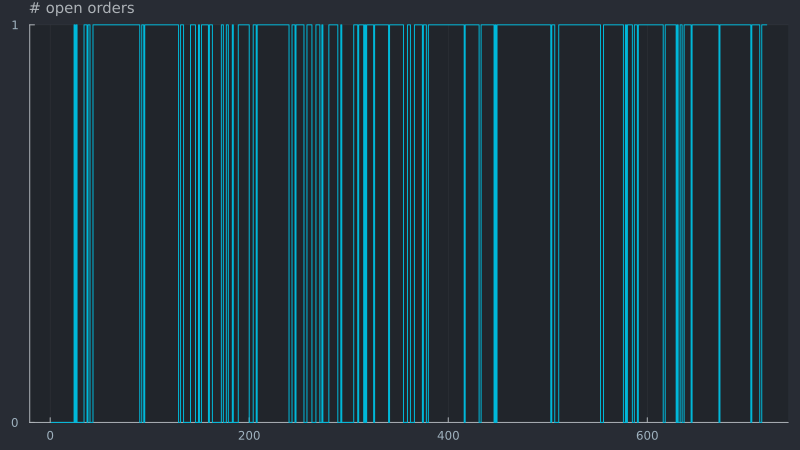

In [7]:
Fastback.plot_open_orders_count(open_orders_data; xaxis_mode=:index)

Drawdown plot

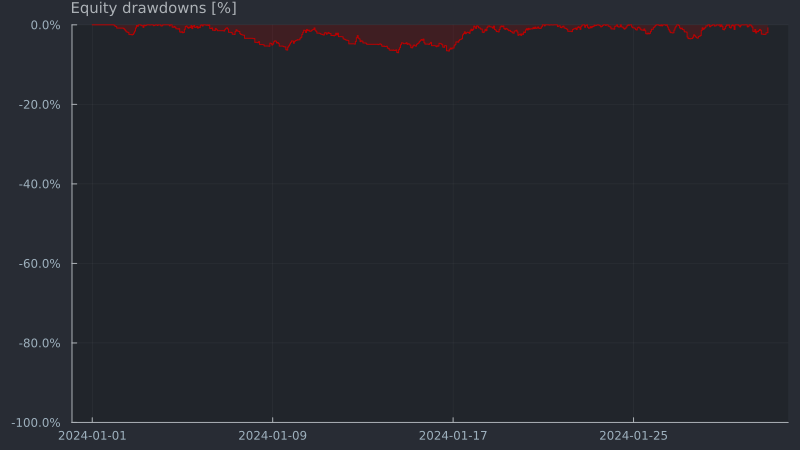

In [8]:
Fastback.plot_drawdown(drawdown_data)

Drawdown plot (index x-axis)

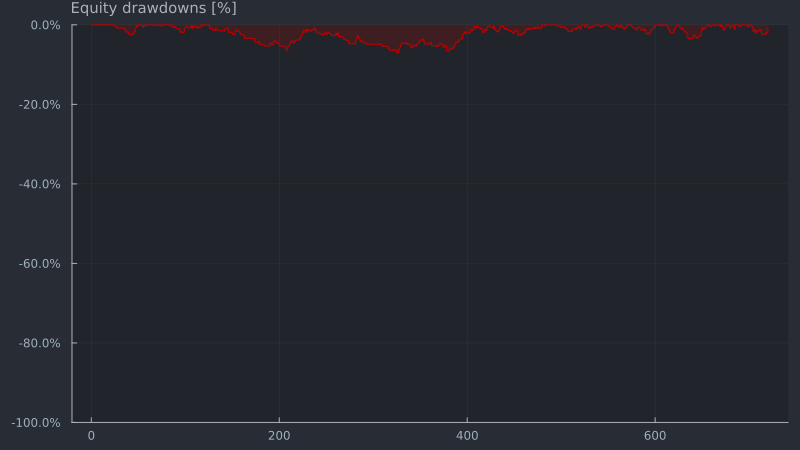

In [9]:
Fastback.plot_drawdown(drawdown_data; xaxis_mode=:index)

Exposure plot (gross, net, long, short)

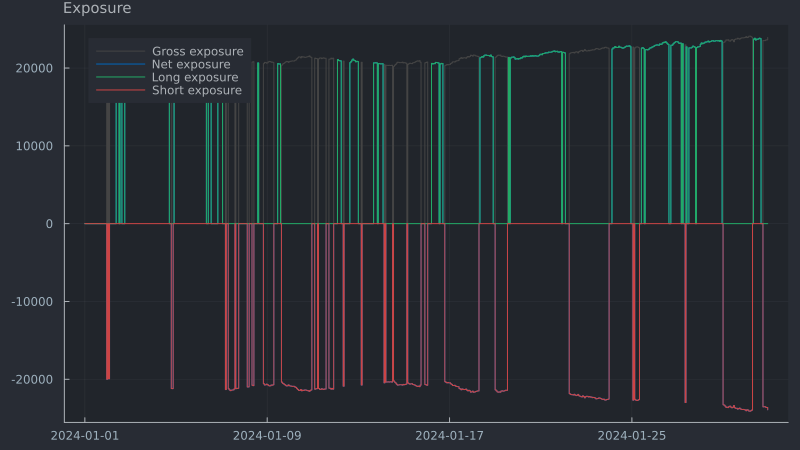

In [10]:
Fastback.plot_exposure(;
    gross=gross_exposure,
    net=net_exposure,
    long=long_exposure,
    short=short_exposure)

Equity + drawdown overlay

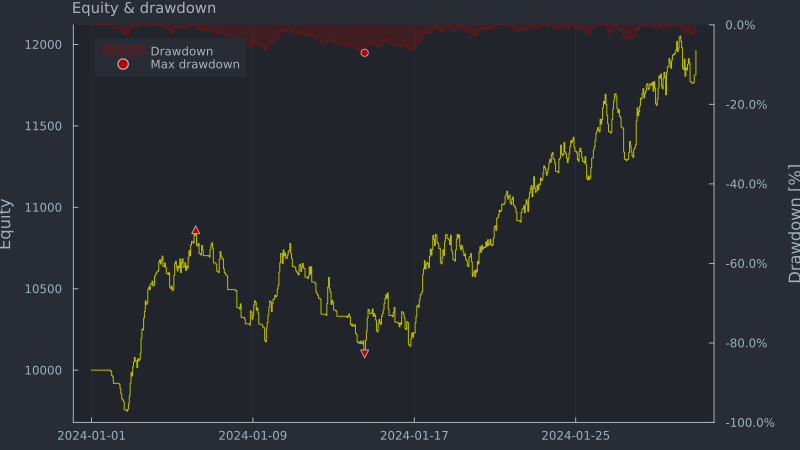

In [11]:
Fastback.plot_equity_drawdown(equity_data, drawdown_data)

---------------------------------------------------------
Overlay helpers (plot_! variants)

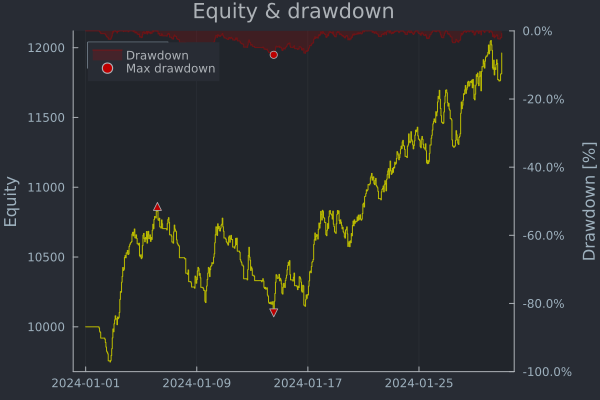

In [12]:
p = plot();
Fastback.plot_balance!(p, balance_data; title="Account");
Fastback.plot_equity!(p, equity_data);
p

p = plot();
Fastback.plot_equity_drawdown!(p, equity_data, drawdown_data; title="Equity & drawdown");
p

---------------------------------------------------------
Cashflow plots

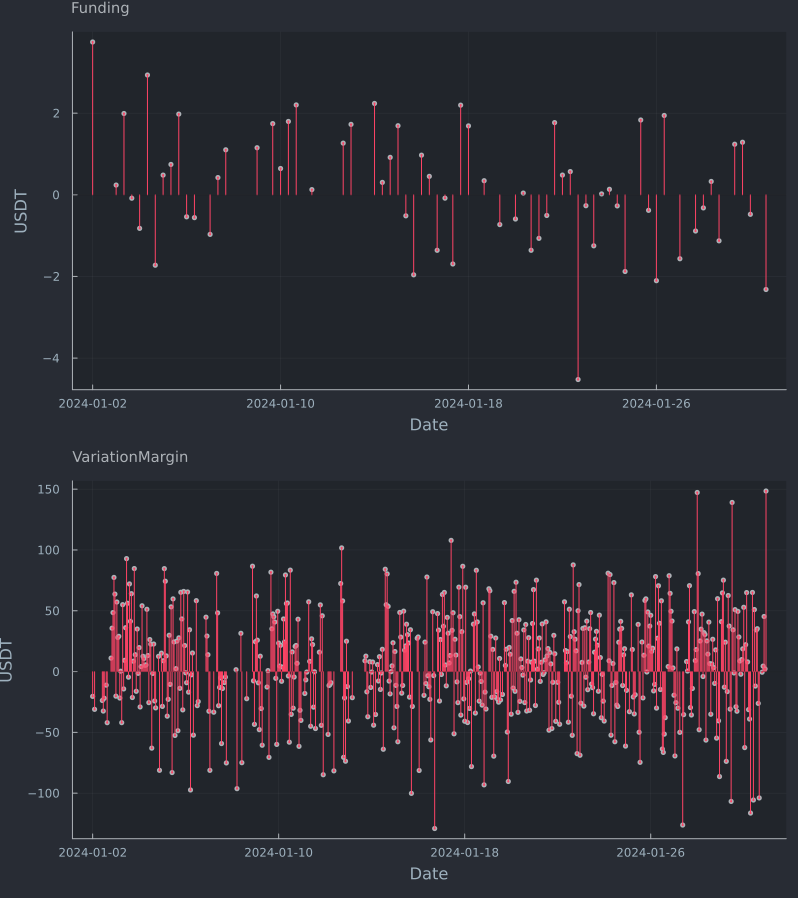

In [13]:
Fastback.plot_cashflows(acc)

---------------------------------------------------------
Return-based plots

Gross returns by day (violin plot)

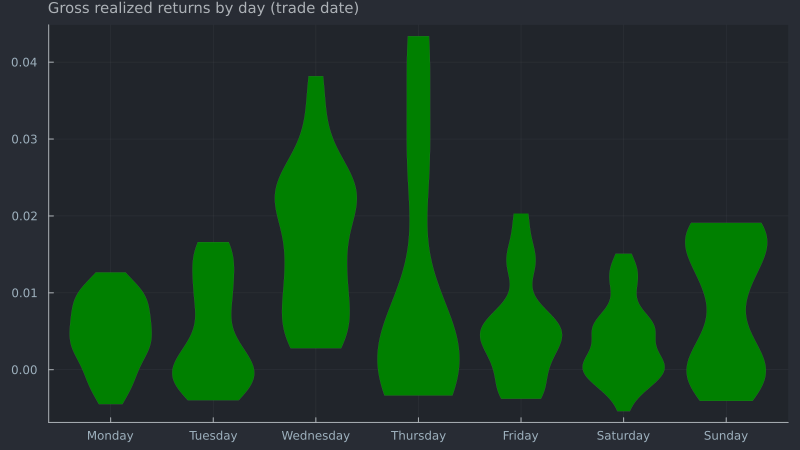

In [14]:
Fastback.plot_violin_realized_returns_by_day(acc.trades; return_basis=:gross)

Net returns by hour (violin plot)

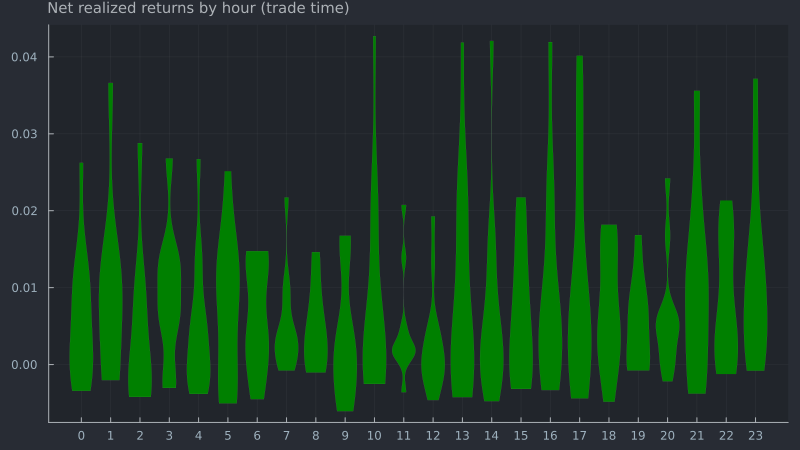

In [15]:
Fastback.plot_violin_realized_returns_by_hour(acc.trades; return_basis=:net)

Cumulative net returns by hour

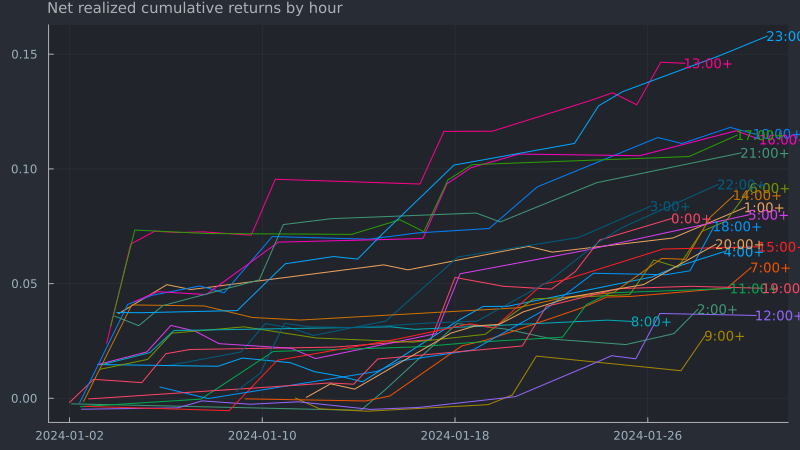

In [16]:
Fastback.plot_realized_cum_returns_by_hour(acc.trades; return_basis=:net)

Cumulative net returns by hour (index x-axis)

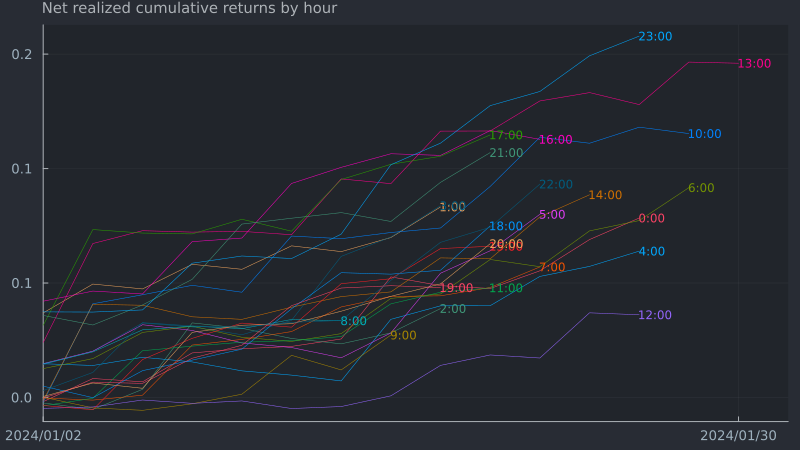

In [17]:
Fastback.plot_realized_cum_returns_by_hour(acc.trades; return_basis=:net, xaxis_mode=:index)

Cumulative gross returns by weekday

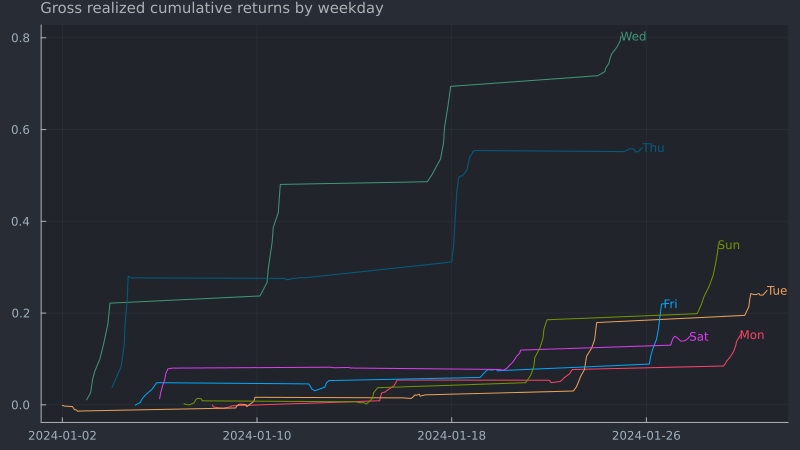

In [18]:
Fastback.plot_realized_cum_returns_by_weekday(acc.trades; return_basis=:gross)

Cumulative gross returns by weekday (index x-axis)

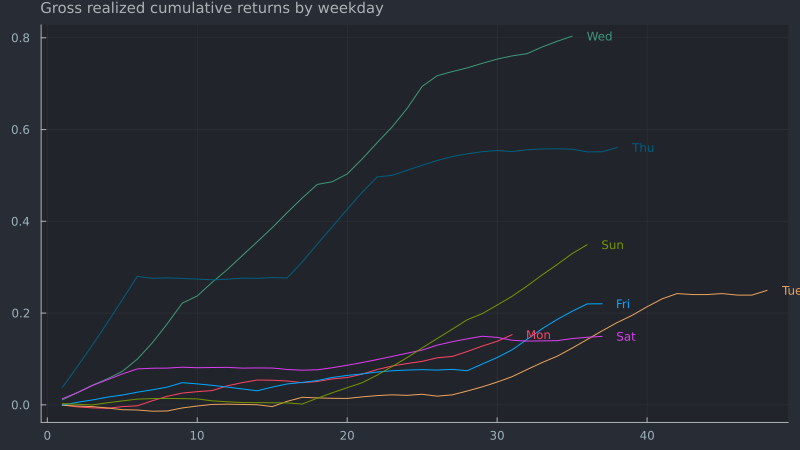

In [19]:
Fastback.plot_realized_cum_returns_by_weekday(acc.trades; return_basis=:gross, xaxis_mode=:index)